# Distinct element estimation using k-th min 

In the lecture, we studied the algorithm named Idealized $F_0$ estimation (slide 19). The algorithm uses a random hash function to map elements from the stream to float values between 0 and 1. Ultimately, it maintains the smallest hash value $V$ and outputs ${1\over V}-1$ as the estimate $\tilde{F}_0$ for the number of distinct elements.

This algorithm uses the idea that the expected value of the smallest hash value is $1\over F_0+1$, where $F_0$ is the number of distinct elements. In fact, we can generally use the $k$-th smallest hash value $V_k$ for $k=1,2,\dots$. We will use the results from exercise 4 to conduct experiments to see how different $k$ values affect the accuracy of your estimate.

[Optional]: Let m be the length of the stream. You can maintaining the k-th smallest element in an unsorted list in time $O(m\log k)$ using min heap, see https://docs.python.org/3/library/heapq.html. 

In [1]:
# Import packages needed.
import random, math
import numpy as np
import matplotlib.pyplot as plt

To test the effect of k, we must first implement a function that takes a data sequence, hash each element to a value between 0 and 1, and returns the k-th smallest hash value. Python has a built-in hash function hash() that takes any hashable object and returns an integer hash. To convert a hash value to a float, use modular the hash with a large int and divide by it, for instance, $MAXINT=2^{63}-1$.

In [2]:
import sys
MAXINT = sys.maxsize

In [42]:
import heapq
def kth_smallest_hash_value(input_list, k):
#     Write your code here
    h = []
    for i in input_list:
        heapq.heappush(h, (hash(i)%MAXINT)/MAXINT)
    for i in range(k):
        res = heapq.heappop(h)
    return res
    

Now let us test k values between 1 to 10. For each k, we will generate a list of 1000 random **strings** using ``str(random.uniform(0,100))``, and estimate its cardinality via the returned value from the function ``kth_smallest_hash_value`` you implemented. For each k, repeat this process 100 times and record the average and std of the estimates. Finally, generate a plot with error bars to show the relation between estimates and k values. Note that the std for small k can be very large, so you may need to set plt.ylim(-1000, 10000) to cap the y-axis for better visualization.

In [50]:
# Write your code here
mean = []
std = []
for k in range(1,11):
    l = [1/kth_smallest_hash_value([str(random.uniform(0,100)) for i in range(1000)], k)-1 for i in range(100)]
    #print(np.asarray(l).mean())
    mean.append(np.mean(l))
    std.append(np.asarray(l).std())

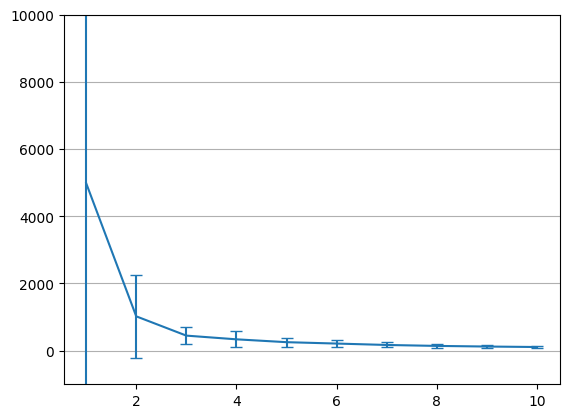

In [51]:
fig, ax = plt.subplots()
ax.errorbar(range(1,11), mean, yerr=std,capsize=4)
ax.set_ylim(-1000,10000)
ax.yaxis.grid(True)

## The median trick useful technique (slide 13)

Please implement the function ``median_trick`` below. 

In [56]:
def median_trick(generator, expectation, var, eps, delta):
    '''
    Input:
        generator - a function that generates one sample from a distribution when being called.
        expectation - Expectation of the distribution
        var - Variance of the distribution
        eps - epsilon (accuracy parameter) as defined in slide 13
        delta - delta (confidence parameter) as defined in slide 13
    Output:
        estimated value Q
    '''
    # Write your code here
    t = math.ceil(math.log(1/delta))
    k = math.ceil(var/(eps ** 2 * expectation **2))
    Z = np.median([np.mean([generator for _ in range(k)]) for _ in range(t)])
    return Z
    

Now we want to test the function with the following idea. Assume Q=2. The unbiased estimator, X of Q, generates estimates that follow a normal distribution with variance equal to 1. The generator for X is already given below as ``normal_generator``. Please generate two plots below. 

- Set eps=0.1, and test how the delta affects the estimates. Range delta in [1e-6, 1e-4, 1e-3, 0.01, 0.1]; repeat the estimation 100 times for each delta value. Generate a plot with std as error bars to show how the average estimates change as the delta changes.

- Set delta=0.1, and test how the epsilon affects the estimates. Range epsilon in [0.01, 0.02, 0.05, 0.1, 0.2]; repeat the estimation 100 times for each epsilon value. Generate a plot with std as error bars to show how the average estimates change as the epsilon changes.

In [57]:
# Don't change
def normal_generator():
    return np.random.normal(2,1)

In [59]:
# Write your code here\
delta = [1e-6,1e-4,1e-3,0.01,.1]
dMean = []
dStd = []
eMean = []
eStd = []
for d in delta:
    l = [median_trick(normal_generator(), 2, 1, .1, d) for _ in range(100)]
    dMean.append(np.mean(l))
    dStd.append(np.std(l))
epsilon = [.01,.02,.05,.1,.2]
for e in epsilon:
    l = [median_trick(normal_generator(), 2, 1, e, .1) for _ in range(100)]
    eMean.append(np.mean(l))
    eStd.append(np.std(l))

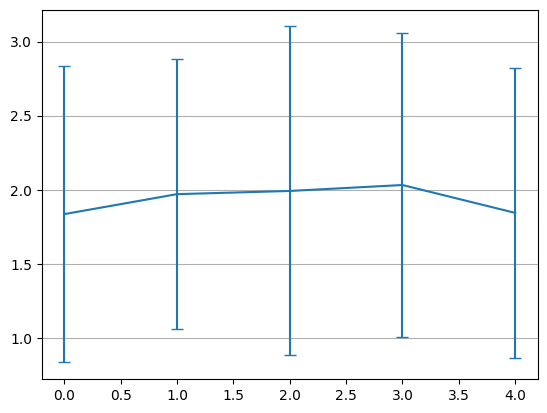

In [62]:
fig, ax = plt.subplots()
ax.errorbar(range(5), dMean, yerr=dStd,capsize=4)
ax.yaxis.grid(True)

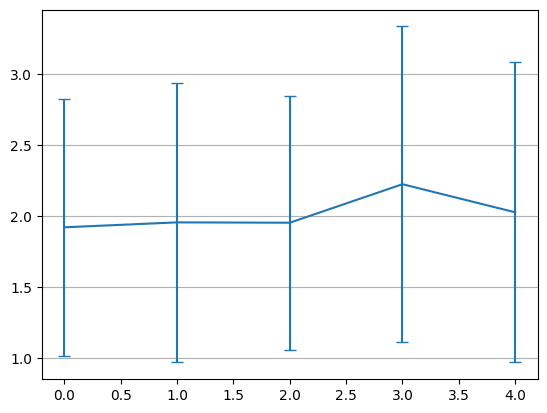

In [63]:
fig, ax = plt.subplots()
ax.errorbar(range(5), eMean, yerr=eStd,capsize=4)
ax.yaxis.grid(True)

## Morris Algorithm (slide 45)

Morris algorithm maintains a counter c that, for every element in the stream, itself increments by 1 with probability $1\over 2^c$. In the end, it outputs an estimate as $2^c-1$.

In this section, we will change the base of this counter (slide 51). Instead of using 2 only, we use any base $1+\alpha$. We now increase the counter c with probability $1\over (1+\alpha)^c$. First, let us implement the function ``morris_update_base_alpha`` below. **This function is called whenever we see an element from the stream to update the counter.**

In [77]:
def morris_update_base_alpha(counter, alpha):
    '''
    Input:
        counter - current value of counter c
        alpha - as defined in slide 51 alpha
    Output:
        updated value of counter c
    '''
    # if reach 1/(1+ alpha) update
    if(random.uniform(0, 1) <= 1/((1+alpha)**counter)):
        counter += 1
    return counter

Now let us test the function with the edge list file "soc-hamsterster.edges" in the same folder. Reading the file line by line in python can generate a stream of strings. Counting the number of strings/lines in this file tells us the number of edges of this "soc-hamsterster" graph. Let us try different alpha values ranging from 2 to 9. Again, for each alpha, estimate the number of lines in the edge list file using the morris algorithm (the key component of which is ``morris_update_base_alpha``), and repeat this 100 times. Besides, check how many bits are needed to maintain the counter via ``math.ceil(math.log(counter, 2))`` at the end of each estimation. Finally, generate two plots with std as error bars to show 

- How the average estimate changes as the alpha value increases. 
- How the space usage (in bits) changes as the alpha value increases.

In [78]:
c = []
avg = []
cStd = []
avgStd = []
for alpha in range(2,10):
    cAcc = []
    avgAcc = []
    for _ in range(100):
        counter = 0
        with open("soc-hamsterster.edges", "r") as f:
            for line in f:
                # process the line here
                counter = morris_update_base_alpha(counter, alpha)
        # end of the estimation
        avgAcc.append(counter)
        cAcc.append(math.ceil(math.log(counter, 2)))
    c.append(np.mean(cAcc))
    avg.append(np.mean(avgAcc))
    cStd.append(np.std(cAcc))
    avgStd.append(np.std(avgAcc))

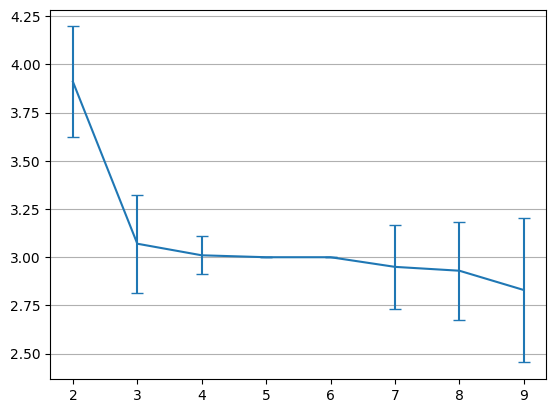

In [81]:
fig, ax = plt.subplots()
ax.errorbar(range(2,10), c, yerr=cStd,capsize=4)
ax.yaxis.grid(True)

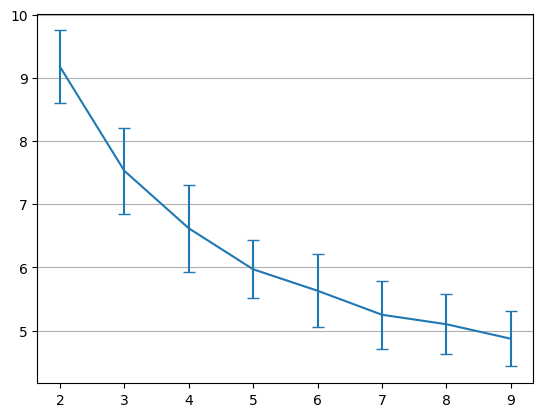

In [80]:
fig, ax = plt.subplots()
ax.errorbar(range(2,10), avg, yerr=avgStd,capsize=4)
ax.yaxis.grid(True)